# Data block API foundations

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_07a import *

In [3]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

## Image ItemList

Previously we were reading in to RAM the whole MNIST dataset at once, loading it as a pickle file. We can't do that for datasets larger than our RAM capacity, so instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them.

Let's use the [imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) and build the data blocks we need along the way.

### Get images

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/root/.fastai/data/imagenette-160')

In [5]:
#export
import PIL, os, mimetypes
from PIL import Image
Path.ls = lambda x : list(x.iterdir())

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/imagenette-160/train'),
 PosixPath('/root/.fastai/data/imagenette-160/val')]

In [7]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imagenette-160/train/n03888257'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n02979186'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n02102040'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03425413'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03000684'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03445777'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n01440764'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03028079'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03417042'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03394916')]

## Check images

In [8]:
path_tench = path/'val'/'n01440764'

In [9]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00034654.JPEG')

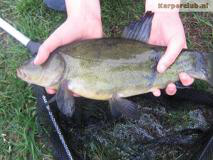

In [10]:
img = PIL.Image.open(img_fn)
img

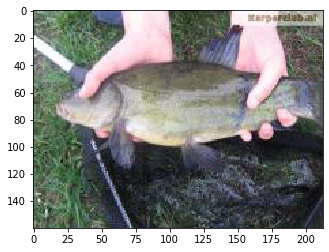

In [11]:
plt.imshow(img);

In [12]:
import numpy
imga = numpy.array(img)

In [13]:
imga.shape

(160, 213, 3)

In [14]:
imga[:10,:10,0]

array([[126, 140, 125, 113, ..., 115, 101,  90,  96],
       [111, 122, 125, 146, ..., 149, 128, 127, 112],
       [111, 108,  97, 113, ..., 129, 128, 139, 126],
       [129, 131, 112, 103, ..., 106, 116, 108, 109],
       ...,
       [105, 103,  78,  75, ..., 100,  87,  83, 111],
       [ 78,  90,  94, 110, ...,  87,  80,  97,  97],
       [ 68,  85,  88, 103, ..., 110, 109, 132, 136],
       [ 95, 124, 124, 108, ..., 148, 157, 144, 138]], dtype=uint8)

Just in case there are other files in the directory (models, texts...) we want to keep only the images. Let's not write it out by hand, but instead use what's already on our computer (the MIME types database).

In [15]:
#export
image_extensions = [k for k,v in mimetypes.types_map.items() if v.startswith('image/')]

In [16]:
image_extensions

['.bmp',
 '.gif',
 '.ico',
 '.ief',
 '.jpe',
 '.jpeg',
 '.jpg',
 '.pbm',
 '.pgm',
 '.png',
 '.pnm',
 '.ppm',
 '.ras',
 '.rgb',
 '.svg',
 '.tif',
 '.tiff',
 '.xbm',
 '.xpm',
 '.xwd']

In [17]:
#export
def setify(o):
    return o if isinstance(0, set) else set(listify(o))

In [18]:
test_eq(setify([1, 2]), {1, 2})
test_eq(setify({1, 2}), {1, 2})
test_eq(setify(None), set())
test_eq(setify(1), {1})

Now let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in `path`.

In [19]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    return [
        p/f for f in fs if not f.startswith('.')
        and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)
    ]

In [20]:
print(path_tench)

/root/.fastai/data/imagenette-160/val/n01440764


In [21]:
print(path_tench); path

/root/.fastai/data/imagenette-160/val/n01440764


PosixPath('/root/.fastai/data/imagenette-160')

In [22]:
files = [o.name for o in os.scandir(path_tench)]
t = _get_files(path_tench, files, extensions=image_extensions)
t[:3]

[PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00034654.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00016018.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00012503.JPEG')]

In [23]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [24]:
get_files(path_tench, extensions=image_extensions)[:3]

[PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00034654.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00016018.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00012503.JPEG')]

In [25]:
get_files(path, recurse=True, extensions=image_extensions, include='train')

[PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_30127.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_38723.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_24216.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_11854.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_14901.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_1769.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_17690.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_16315.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_22484.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_15382.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_34031.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03

In [26]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [27]:
([f for f in all_fns if f.name.find('val') > -1])

[PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00022496.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00030583.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00020698.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00034544.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00010460.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009370.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00010336.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00041925.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00039045.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00011324.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00047

Imagenet is 100 times bigger than imagenette, so we need this to be fast.

In [28]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

42.4 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modeling

What we need to do:

- Get files
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

### Get files

We use the `ListContainer` class from notebook 06 to store our objects in an `ItemList`. The `get` method will need to be subclassed to explain how to access an element (open an image for instance), then the private `_get` method can allow us to apply any additional transform to it.

`new` will be used in conjunction with `__getitem__` (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [29]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o : getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key):
        x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path = Path(path)
        self.tfms = tfms
        
    def __repr__(self):
        return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None:
            cls = self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def get(self, i):
        return i
    
    def _get(self, i):
        return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): 
            return [self._get(o) for o in res]
        return self._get(res)

In [30]:
#export
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None:
            extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return PIL.Image.open(fn)

Transforms aren't only used for data augmentation. To allow total flexibility, `ImageList` returns the raw PIL image. The first thing is to convert it to 'RGB' (or something else).

Transforms only need to be functions that take an element of the `ItemList` and transform it. If they need state, they can be defined as a class. Also, having them as a class allows to define an `_order` attribute (default 0) that is used to sort the transforms.

In [31]:
#export

class Transform():
    _order = 0
    
class MakeRGB(Transform):
    def __call__(self, item):
        return item.convert('RGB')
    
def make_rgb(item):
    return item.convert('RGB')

In [32]:
il = ImageList.from_files(path, tfms=make_rgb)

In [33]:
il

ImageList (13394 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_30127.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_38723.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_24216.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_11854.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_14901.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_1769.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_17690.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_16315.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_22484.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_15382.JPEG')...]
Path: /root/.fastai/data/imagenette-160

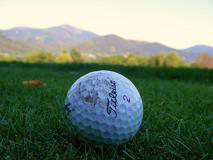

In [34]:
img = il[7001]
img

In [35]:
il[:2]

[<PIL.Image.Image image mode=RGB size=227x160 at 0x7F9762058F10>,
 <PIL.Image.Image image mode=RGB size=240x160 at 0x7F9761A050D0>]

### Split validation set

Here, we need to split the files between those in the folder train and those in the folder val.

In [36]:
il.items[0]

PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_30127.JPEG')

In [37]:
fn = il.items[0]

In [38]:
fn.parent.parent.name

'train'

In [39]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp == valid_name else False if gp == train_name else None

In [40]:
grandparent_splitter(Path('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00022496.JPEG'))

In [41]:
#export
def split_by_func(items, f):
    mask = [f(o) for o in items]
    t = []
    f = []
    for i, m in zip(items, mask):
        if m:
            t.append(i)
        elif m == False:
            f.append(i)
    return f, t

In [42]:
splitter = partial(grandparent_splitter, valid_name='val')
f, t = split_by_func(il.items, splitter)

In [43]:
len(f), len(t)

(12894, 500)

In [44]:
%time train, valid = split_by_func(il.items, splitter)

CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 22.9 ms


In [45]:
len(train), len(valid)

(12894, 500)

In [46]:
#export
class SplitData():
    def __init__(self, train, valid):
        self.train, self.valid = train, valid
        
    def __getattr__(self, k):
        return getattr(self.train, k)
    
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self, data:Any):
        self.__dict__.update(data)
        
    @classmethod
    def split_by_func(cls, il, f):
        train, valid = map(il.new, split_by_func(il.items, f))
        return cls(train, valid)
    
    def __repr__(self):
        return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [47]:
sd = SplitData.split_by_func(il, splitter)
sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_30127.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_38723.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_24216.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_11854.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_14901.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_1769.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_17690.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_16315.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_22484.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_15382.JPEG')...]
Path: /root/.fastai/data/imagenette-160
Valid: ImageList (500 items)
[PosixPath('/root/.fastai/data/imagen

### Labeling

Labeling has to be done *after* splitting, because it uses *training* set information to apply to the *validation* set, using a *Processor*.

A *Processor* is a transformation that is applied to all the inputs once at initialization, with some *state* computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be **processing texts** to **tokenize**, then **numericalize** them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in **tabular data**, where we **fill missing values** with (for instance) the median computed on the training set. That statistic is stored in the inner state of the *Processor* and applied on the validation set.

In our case, we want to **convert label strings to numbers** in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this *vocab*.

In [48]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort:
        res.sort()
    return res

In [49]:
uniqueify({'a': 1, 'a': 1, 'b': 2, 'c': None}, sort=True)

['a', 'b', 'c']

In [50]:
{v: k for k, v in enumerate(uniqueify({'a': 1, 'a': 1, 'b': 2, 'c': None}, sort=True))}

{'a': 0, 'b': 1, 'c': 2}

In [51]:
{v: k for k, v in enumerate(uniqueify({'a': 1, 'a': 1, 'b': 2, 'c': None}, sort=True))}['a']

0

First, let's define the processor.

In [52]:
#export
class Processor():
    def process(self, items):
        return items
    
class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

Here we label according to the folders of the images, so simply `fn.parent.name`. We label the training set first with a newly created `CategoryProcessor` so that it computes its inner `vocab` on that set. Then we label the validation set using the same processor, which means it uses the same `vocab`. The end result is another `SplitData` object.

In [53]:
#export
def parent_labeler(fn):
    return fn.parent.name

def _label_by_func(ds, f, cls=ItemList):
    return cls([f(o) for o in ds.items], path=ds.path)

In [54]:
_label_by_func(il, parent_labeler)

ItemList (13394 items)
['n03888257', 'n03888257', 'n03888257', 'n03888257', 'n03888257', 'n03888257', 'n03888257', 'n03888257', 'n03888257', 'n03888257'...]
Path: /root/.fastai/data/imagenette-160

In [55]:
#export

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    
    def process(self, il, proc):
        return il.new(compose(il.items, proc))
    
    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x = self.process(x, proc_x)
        self.y = self.process(y, proc_y)
        self.proc_x = proc_x
        self.proc_y = proc_y
        
    def __repr__(self):
        return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\ny_class:{[self.y_obj(i) for i in self.y[:20]]}...'
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)
    
    def x_obj(self, idx):
        return self.obj(self.x, idx, self.proc_x)
    
    def y_obj(self, idx): 
        return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx, torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item
    
    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(x=il, y=_label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

In [56]:
LabeledData.label_by_func(sd.train, parent_labeler, proc_y=CategoryProcessor())

LabeledData
x: ImageList (12894 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_30127.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_38723.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_24216.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_11854.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_14901.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_1769.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_17690.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_16315.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_22484.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_15382.JPEG')...]
Path: /root/.fastai/data/imagenette-160
y: ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /r

In [57]:
#export

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train, valid)

In [58]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [59]:
ll.train

LabeledData
x: ImageList (12894 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_30127.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_38723.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_24216.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_11854.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_14901.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_1769.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_17690.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_16315.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_22484.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03888257/n03888257_15382.JPEG')...]
Path: /root/.fastai/data/imagenette-160
y: ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /r

In [60]:
ll.valid

LabeledData
x: ImageList (500 items)
[PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00022496.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00030583.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00020698.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00034544.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00010460.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009370.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00010336.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00041925.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00039045.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00011324.JPEG')...]
Path: /root/.fastai/data/imagenette-160
y: ItemLi

In [61]:
ll.valid.proc_y

In [62]:
assert ll.train.proc_y is ll.valid.proc_y

In [63]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03888257', ['n03888257', 'n03888257'])

In [64]:
len(ll.train), len(ll.valid)

(12894, 500)

### Transform to tensor

In [65]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=227x160 at 0x7F9761A23A50>, 0)

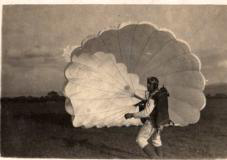

In [66]:
ll.train[0][0]

To be able to put all our images in a batch, we need them to have all the same size. We can do this easily in PIL.

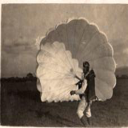

In [67]:
ll.train[0][0].resize((128,128))

The first transform resizes to a given size, then we convert the image to a by tensor before converting it to float and dividing by 255. We will investigate data augmentation transforms at length in notebook 10.

In [68]:
#export

class ResizeFixed(Transform):
    _order = 10
    def __init__(self, size):
        if isinstance(size, int):
            size = (size, size)
        self.size = size
        
    def __call__(self, item):
        return item.resize(self.size, PIL.Image.BILINEAR)

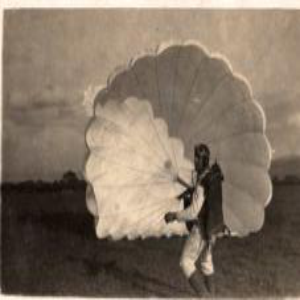

In [69]:
test_resize = ResizeFixed(300)
test_resize(ll.train[0][0])

In [70]:
#export
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h= item.size
    return res.view(h, w, -1).permute(2, 0, 1)
to_byte_tensor._order = 20

In [71]:
to_byte_tensor(ll.train[0][0]).shape

torch.Size([3, 160, 227])

In [72]:
#export
def to_float_tensor(item):
    return item.float().div_(255.)

to_float_tensor._order = 30

In [73]:
to_float_tensor(to_byte_tensor(test_resize(ll.train[0][0]))).shape

torch.Size([3, 300, 300])

In [74]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [75]:
#export
def show_image(im, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1, 2, 0))

In [76]:
x,y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

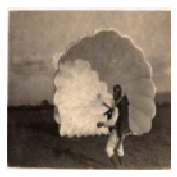

In [77]:
show_image(x)

## Modeling

### DataBunch

Now we are ready to put our datasets together in a `DataBunch`.

In [78]:
bs=64

In [79]:
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=4)

In [80]:
xb, yb = next(iter(train_dl))

In [81]:
xb.shape

torch.Size([64, 3, 128, 128])

We can still see the images in a batch and get the corresponding classes.

'n02102040'

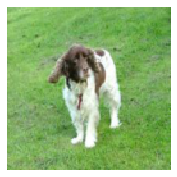

In [82]:
show_image(xb[0])
ll.train.proc_y.vocab[yb[0]]

In [83]:
yb

tensor([2, 5, 7, 7, 0, 2, 8, 6, 8, 7, 7, 3, 7, 7, 5, 4, 2, 7, 7, 6, 7, 1, 5, 5,
        5, 4, 1, 4, 1, 7, 6, 6, 6, 9, 4, 0, 4, 7, 3, 2, 1, 9, 4, 3, 9, 0, 6, 9,
        7, 3, 6, 7, 9, 1, 0, 2, 5, 7, 7, 0, 3, 7, 8, 4])

We change a little bit our `DataBunch` to add a few attributes: `c_in` (for channel in) and `c_out` (for channel out) instead of just `c`. This will help when we need to build our model.

In [84]:
#export
class DataBunch():
    
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl, valid_dl, c_in, c_out
        
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_dl.dataset

Then we define a function that goes directly from the `SplitData` to a `DataBunch`.

In [85]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    train_dl, valid_dl = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(train_dl, valid_dl, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

This gives us the full summary on how to grab our data and put it in a `DataBunch`:

In [86]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [87]:
data.valid_ds

LabeledData
x: ImageList (500 items)
[PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00022496.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00030583.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00020698.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00034544.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00010460.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009370.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00010336.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00041925.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00039045.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00011324.JPEG')...]
Path: /root/.fastai/data/imagenette-160
y: ItemLi

### Model

In [88]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback]

We will normalize with the statistics from a batch.

In [89]:
m,s = xb.mean((0,2,3)).cuda(),xb.std((0,2,3)).cuda()
m,s

(tensor([0.4484, 0.4477, 0.4199], device='cuda:0'),
 tensor([0.2649, 0.2592, 0.2848], device='cuda:0'))

In [90]:
#export

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])

In [91]:
_m.shape

torch.Size([3])

In [92]:
_m[...,None,None].shape

torch.Size([3, 1, 1])

In [93]:
_m.view((3, 1, 1)).shape

torch.Size([3, 1, 1])

In [94]:
#export

def normalize_chan(x, mean, std):
    return (x - mean[..., None, None]) / std[..., None, None]

In [95]:
#export
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [96]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [97]:
nfs = [64,64,128,256]

In [98]:
#export
import math

def prev_pow_2(x):
    return 2 ** math.floor(math.log2(x))

In [99]:
x_tmp = 3*3*3
math.log2(x_tmp), prev_pow_2(x_tmp), 2**math.log2(x_tmp)

(4.754887502163468, 16, 26.999999999999993)

In [100]:
#export

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf,  stride=2):
        return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers = [f(l1, l2, stride=1), f(l2, l2*2, stride=2), f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs) - 1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [101]:
sched = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.1, 0.3, 0.05))

In [102]:
learn, run = get_learn_run(nfs, data, .2, conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [103]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

Let's have a look at our model using Hooks. We print the layers and the shapes of their outputs.

In [104]:
#export
def model_summary(run, learn, data, find_all=False):
    xb, yb = get_batch(data.train_dl, run)
    device = next(learn.model.parameters()).device #Model may not be on the GPU yet
    xb, yb = xb.to(device), yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook, mod, inp, out : print(f'{mod}\n{out.shape}\n')
    with Hooks(mods, f):
        learn.model(xb)

In [105]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([64, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([64, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([64, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([64, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3

In [106]:
%time run.fit(5, learn)

train: [1.7210490950248178, tensor(0.4096, device='cuda:0')]
valid: [1.5413399658203124, tensor(0.4800, device='cuda:0')]
train: [1.312800375901582, tensor(0.5661, device='cuda:0')]
valid: [1.2368037109375, tensor(0.5820, device='cuda:0')]
train: [0.9425202765094229, tensor(0.6936, device='cuda:0')]
valid: [1.19024609375, tensor(0.6440, device='cuda:0')]
train: [0.6312204925740654, tensor(0.7986, device='cuda:0')]
valid: [0.8151799926757812, tensor(0.7440, device='cuda:0')]
train: [0.3712716579659144, tensor(0.8936, device='cuda:0')]
valid: [0.814424560546875, tensor(0.7480, device='cuda:0')]
CPU times: user 19.1 s, sys: 2.33 s, total: 21.4 s
Wall time: 22.5 s


In [107]:
!python notebook2script.py 08_data_block.ipynb

Converted 08_data_block.ipynb to exp/nb_08.py
